# This repo is an implmentation of PCA as an autoencoder in PyTorch
![mathematical equation.JPG](<attachment:mathematical equation.JPG>)
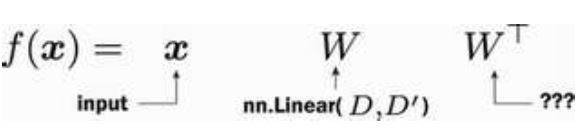

In [12]:
import torch
from torch import nn
import torch.nn.functional as F
from utils import View
from utils import train_network
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import seaborn as sns

In [2]:
D=28*28               # Dimension of the input data
n=2                   # no of hidden layers
C=1                   # no of channels
classes=10            # output classes

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class TransposeLinear(nn.Module):
    def __init__(self,linearlayer,bias=True):
        '''
        This function takes a linear layer and
        transposes it through weight sharing techniques 
        bias term = True means we will create a new bias for the transposed layer
        '''
        super().__init__()
        self.weight = linearlayer.weight

        if bias:
            self.bias = nn.Parameter(torch.Tensor(linearlayer.weight.shape[1]))
        else:
            self.register_parameter('bias',None)


    def forward(self,x:torch.Tensor):
        return F.linear(x,self.weight.t(),self.bias)

In [5]:
#Since we will share the weights of the linear layer, lets define it separately
linearLayer = nn.Linear(D,  n, bias=False)
#The encoder just falltens and then uses the linear layer
PCA_encoder = nn.Sequential(
    nn.Flatten(),
    linearLayer,
)
#The decoder uses our TransposeLinear layer + the now shared linearLayer object 
PCA_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    View(-1, 1, 28, 28)#Shape the data back to it's original form [View function is imported from utils.py]
)

In [6]:
#Define a final PCA model that is the sequence of an encoder, followed by a decoder
PCA_model = nn.Sequential(
    PCA_encoder,
    PCA_decoder
)

### We have everything we need to train up this autoencoder. 
But to make it truly PCA, we need to add
the W*W⊤ = I constraint.
 This constraint has a name: orthogonality.

In [7]:
torch.manual_seed(42)
nn.init.orthogonal_(linearLayer.weight)

Parameter containing:
tensor([[ 0.0688,  0.0531,  0.0322,  ...,  0.0275, -0.0274, -0.0339],
        [ 0.0017,  0.0038,  0.0273,  ...,  0.0153, -0.0002, -0.0210]],
       requires_grad=True)

In [8]:
mse_loss = nn.MSELoss() #Original loss function

def mseWithOrthoLoss(x, y):#our PCA loss function
    #Grabing W from the linearLayer object we saved earlier. 
    W = linearLayer.weight
    #The identity matrix that is the target for the regularized
    I = torch.eye(W.shape[0]).to(device)
    #compute the original loss $\ell_{\mathit{MSE}}(f(\boldsymbol{x}), \boldsymbol{x})$
    normal_loss =  mse_loss(x, y) 
    #compute the regularizer penalty $\ell_{\mathit{MSE}}(W^\top W, \boldsymbol{I})$
    regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)
    #return the sum of the two losses
    return normal_loss + regularization_loss

In [9]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs. 
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x#just throw away the original label. 

In [ ]:
train_data = AutoEncodeDataset(MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data_xy = MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

In [ ]:
train_network(PCA_model, mseWithOrthoLoss, train_loader, test_loader=test_loader, epochs=10, device=device)

In [ ]:
def encode_batch(encoder, dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert. 

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset, and `labels` are the original labels provided by the `dataset_to_encode`
    """
    #Create space to store the results
    projected = []
    labels = []
    #Switch to eval mode
    encoder = encoder.eval()
    #Switching to CPU mode for simplicty, but you don't have to. 
    encoder = encoder.cpu()
    with torch.no_grad():#We don't want to train, so torch.no_grad! 
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu()) #encode the original data
            projected.append( z.numpy() ) #store the encoded version & label
            labels.append( y.cpu().numpy().ravel() )
    #Turn the results into single large numpy arrays
    projected = np.vstack(projected)
    labels = np.hstack(labels)
    #return the results
    return projected, labels
#Now lets project our data
projected, labels = encode_batch(PCA_encoder, test_data_xy)

In [ ]:
sns.scatterplot(x=projected[:,0],
                y=projected[:,1],
                hue=[str(l) for l in labels],
                hue_order=[str(i) for i in range(10)],
                legend="full")